# Time projectors
These are used to extend a pathway to cover later times. For instance, if you know the CO2 pathway prior to 2030, can you estimate what it will look like up until 2100? Currently there is only one such method, the Extend Latest Time Quantile.

In [1]:
# Basic setup
import matplotlib.pyplot as plt
import pandas as pd

import silicone.time_projectors as timeproj
from silicone.utils import (
    download_or_load_sr15,
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
# Import the data to use
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "WITCH*",
]
sr15_data = download_or_load_sr15("./sr15_scenarios.csv", valid_model_ids)

pyam.core - INFO: Reading file `./sr15_scenarios.csv`


## Extend Latest Time Quantile
This applies the same logic as the EQW but extends the time period of the selected emission variable to the latest time in the infiller database. (If you only want to infill a shorter time, you can pre-filter the infiller database.) 

In [3]:
# Select a subset of data to use as the infiller database. Note we only need one variable in the data
lead = "Emissions|CO2"
sr15_data_quantile = sr15_data.filter(
    model=["WITCH-GLOBIOM 4.2"], variable=lead
)
sr15_data_quantile.head()

,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2005,31743.82847
1,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2010,34057.08892
2,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2015,35659.76850
3,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2020,37303.32932
4,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2025,21322.81018


In [4]:
# Use another subset of the data to be infilled. 
filler_input = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1000", variable=lead
)
# Select the times of data we pretend to know
short_filler_data = filler_input.filter(year=[2005, 2010, 2020, 2030])

So we have a dataset up to 2030 and want to extend the CO2 pathway to 2100:

In [5]:
extender = timeproj.ExtendLatestTimeQuantile(
    sr15_data_quantile
)
# Only one argument (the emission name) is needed in derive relationship
filler = extender.derive_relationship(lead)
extension = filler(short_filler_data)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.


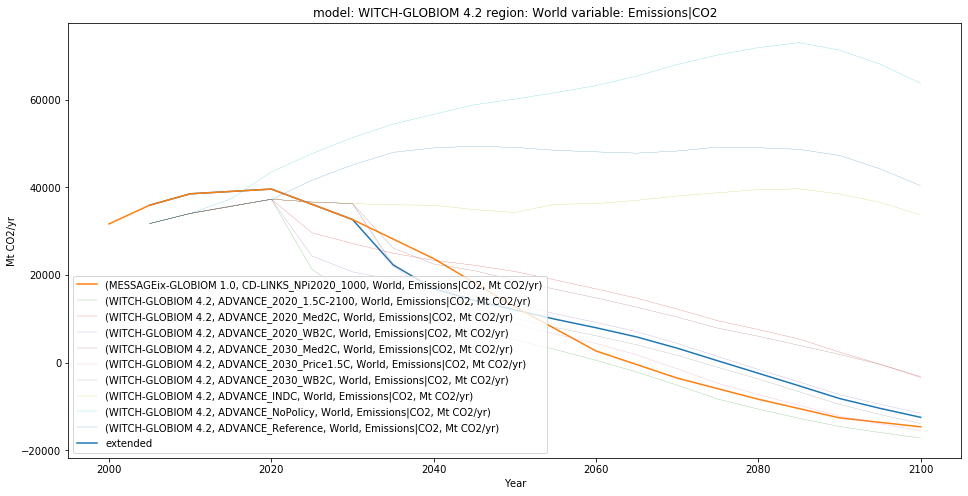

In [6]:
extended_df = short_filler_data.append(extension)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
extended_df.line_plot(ax=ax, label="extended")
filler_input.line_plot(ax=ax)
sr15_data_quantile.filter(variable="Emissions|CO2").line_plot(
    ax=ax, linewidth=0.2
)

As this plot shows, the assumption that the scenario will remain in a constant position relative to the other scenarios does not always hold, and the infilled line takes on one of the strange kinks in the infiller database at 2030. Better results might be obtained if we used scenarios with more similar trajectories.

In [7]:
# Here we use similar scenarios
model_match = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", variable=lead).filter(
    scenario="CD-LINKS_NPi2020_1000", keep=False
)
extender = timeproj.ExtendLatestTimeQuantile(
    model_match
)
# Only one argument (the emission name) is needed in derive relationship
filler = extender.derive_relationship(lead)
extension = filler(short_filler_data)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.


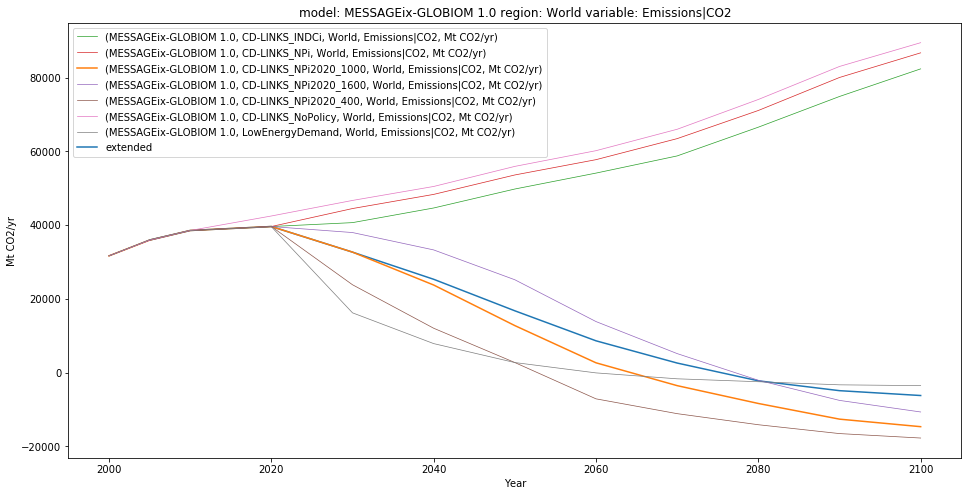

In [8]:
extended_df = short_filler_data.append(extension)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
extended_df.line_plot(ax=ax, label="extended")
filler_input.line_plot(ax=ax)
model_match.filter(variable="Emissions|CO2").line_plot(
    ax=ax, linewidth=0.7
)

Here the lineshape is more consistent in both cases. 